In [ ]:
import scanpy as sc
import numpy as np
import os

os.makedirs('../data', exist_ok=True)
os.makedirs('../data/proc', exist_ok=True)

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Download datasets

## PMBC 10k

In [ ]:
!wget http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_10k_protein_v3/pbmc_10k_protein_v3_filtered_feature_bc_matrix.tar.gz -O ../data/pbmc_10k_protein_v3_filtered_feature_bc_matrix.tar.gz
!cd ../data; tar -xzf pbmc_10k_protein_v3_filtered_feature_bc_matrix.tar.gz


In [3]:
data_path = '../data/filtered_feature_bc_matrix'
results_file = '../data/proc/pbmc10k.h5ad'

# Data preprocessing

In [4]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

scanpy==1.4.3 anndata==0.6.20 umap==0.3.9 numpy==1.16.4 scipy==1.2.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [5]:
adata = sc.read_10x_mtx(
            data_path,  # the directory with the `.mtx` file
            var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
            cache=True)                                # write a cache file for faster subsequent reading

... reading from cache file cache/..-data-filtered_feature_bc_matrix-matrix.h5ad


In [6]:
sc.settings.set_figure_params(dpi=80)

In [7]:
adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

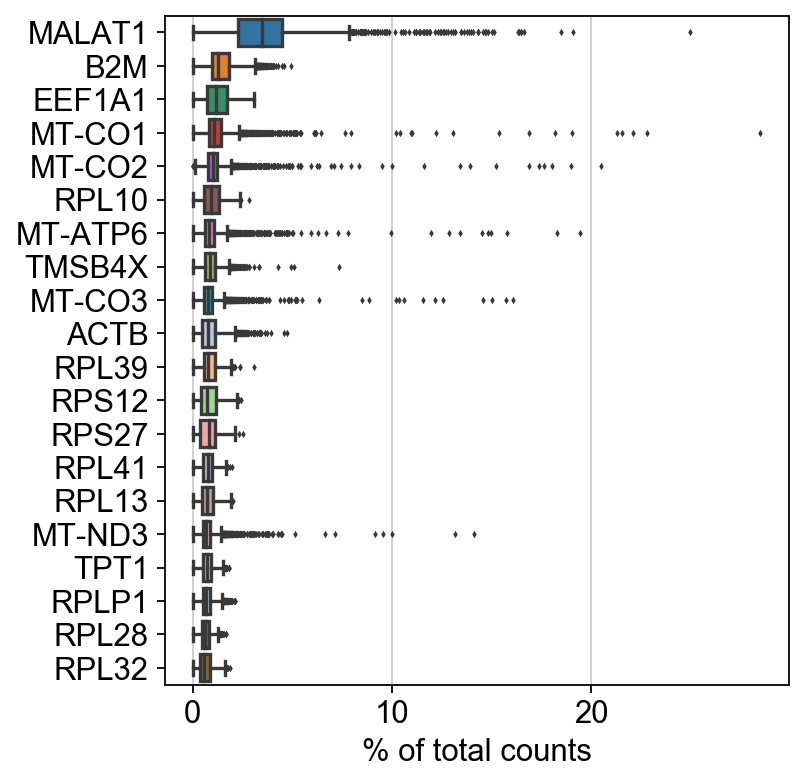

Trying to set attribute `.obs` of view, making a copy.


filtered out 9 cells that have less than 200 genes expressed
filtered out 15484 genes that are detected in less than 3 cells


In [8]:
# Show those genes that yield the highest fraction of counts in each single cells, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20)


# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [9]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

... storing 'feature_types' as categorical


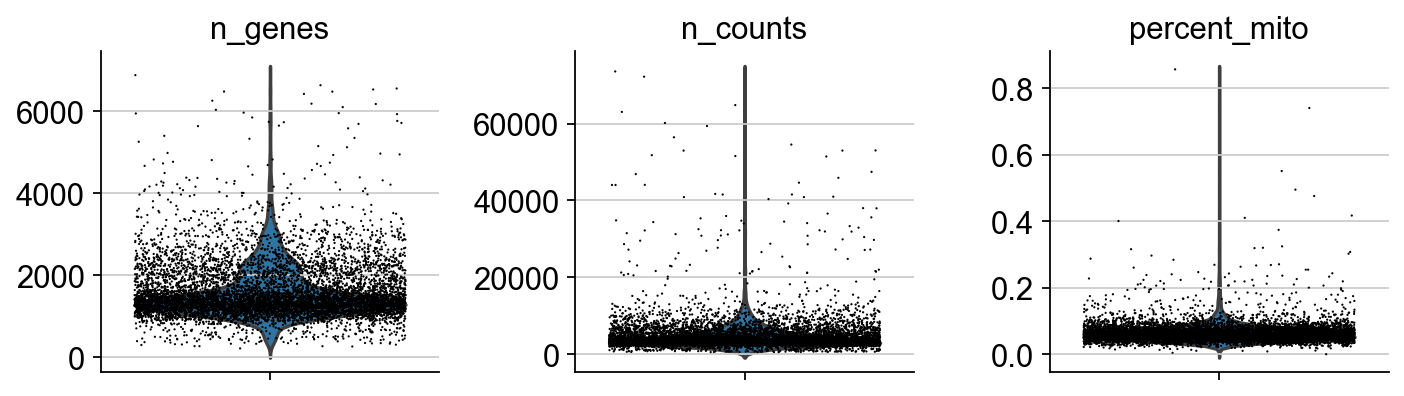

In [10]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

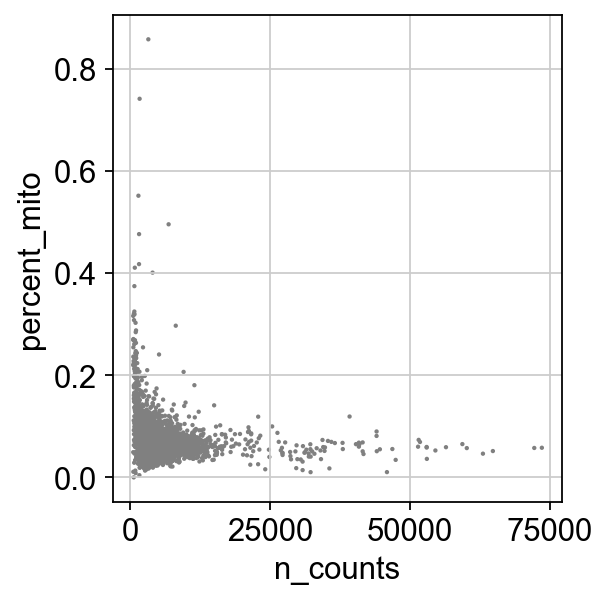

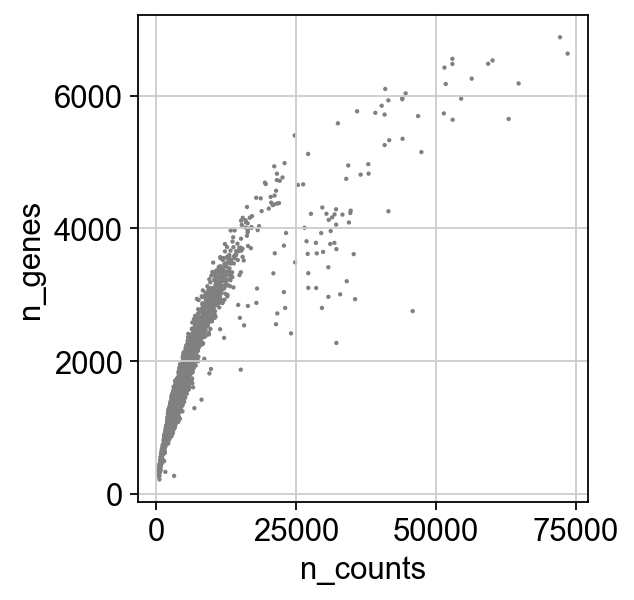

In [11]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [12]:
adata = adata[adata.obs['n_genes'] < 4000, :]
adata = adata[adata.obs['percent_mito'] < 0.3, :]

In [13]:
# Data in log scale
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

adata.raw = adata

Trying to set attribute `.obs` of view, making a copy.


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


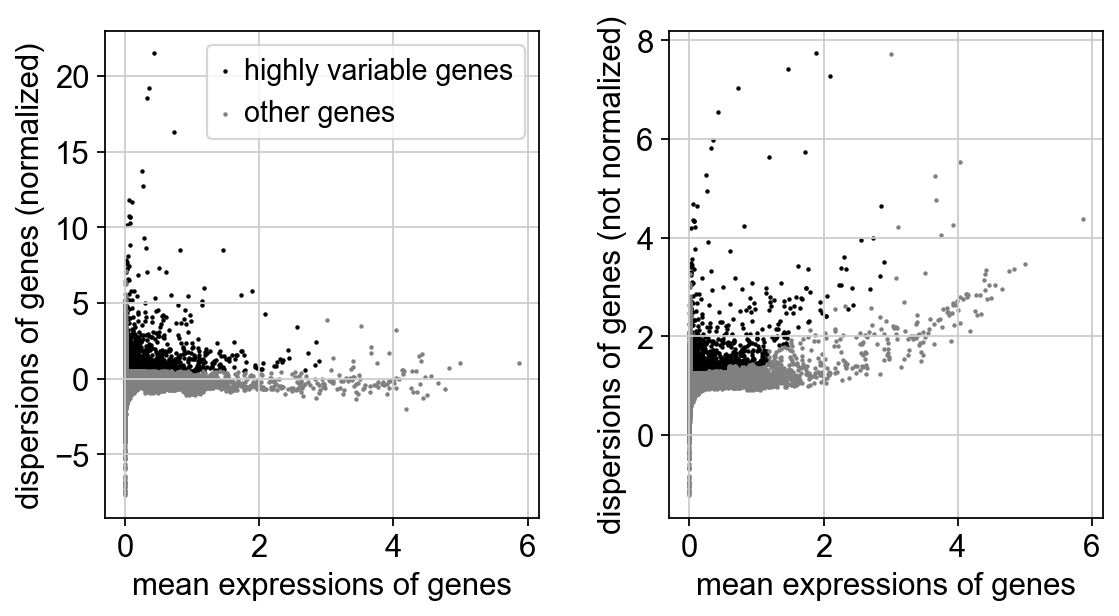

In [14]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [15]:
adata = adata[:, adata.var['highly_variable']]

In [16]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:37.47)


In [17]:
sc.pp.scale(adata, max_value=10)

In [18]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:04.98)


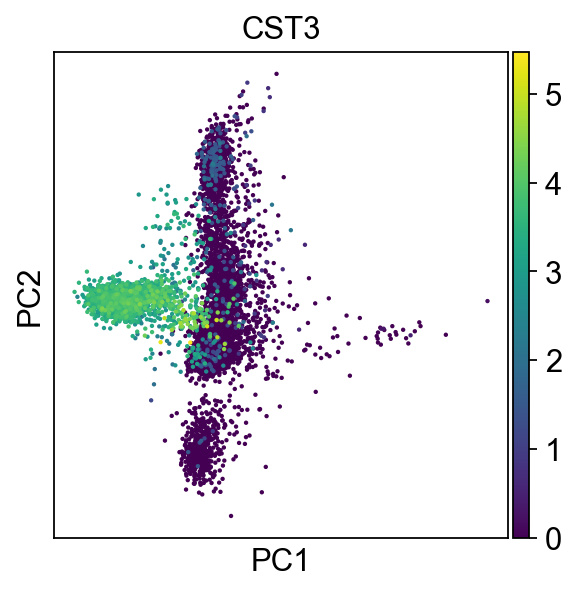

In [19]:
sc.pl.pca(adata, color='CST3')

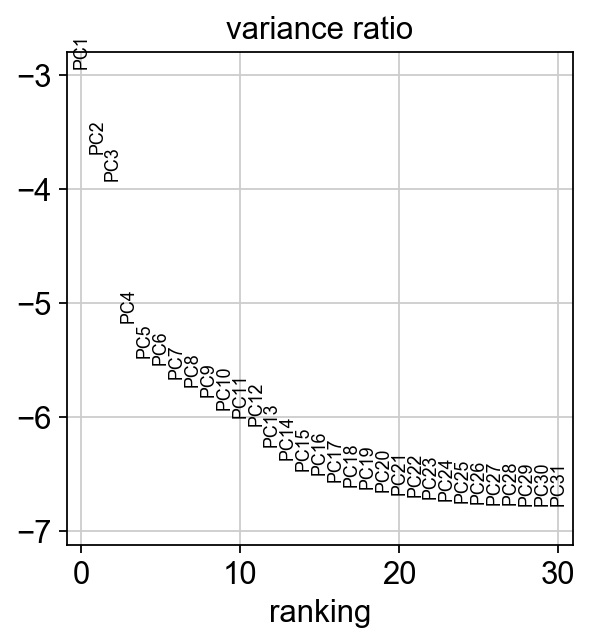

In [20]:
sc.pl.pca_variance_ratio(adata, log=True)

In [21]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:08.80) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [22]:
sc.tl.umap(adata)

computing UMAP
    using 'X_pca' with n_pcs = 50
    finished (0:00:30.16) --> added
    'X_umap', UMAP coordinates (adata.obsm)


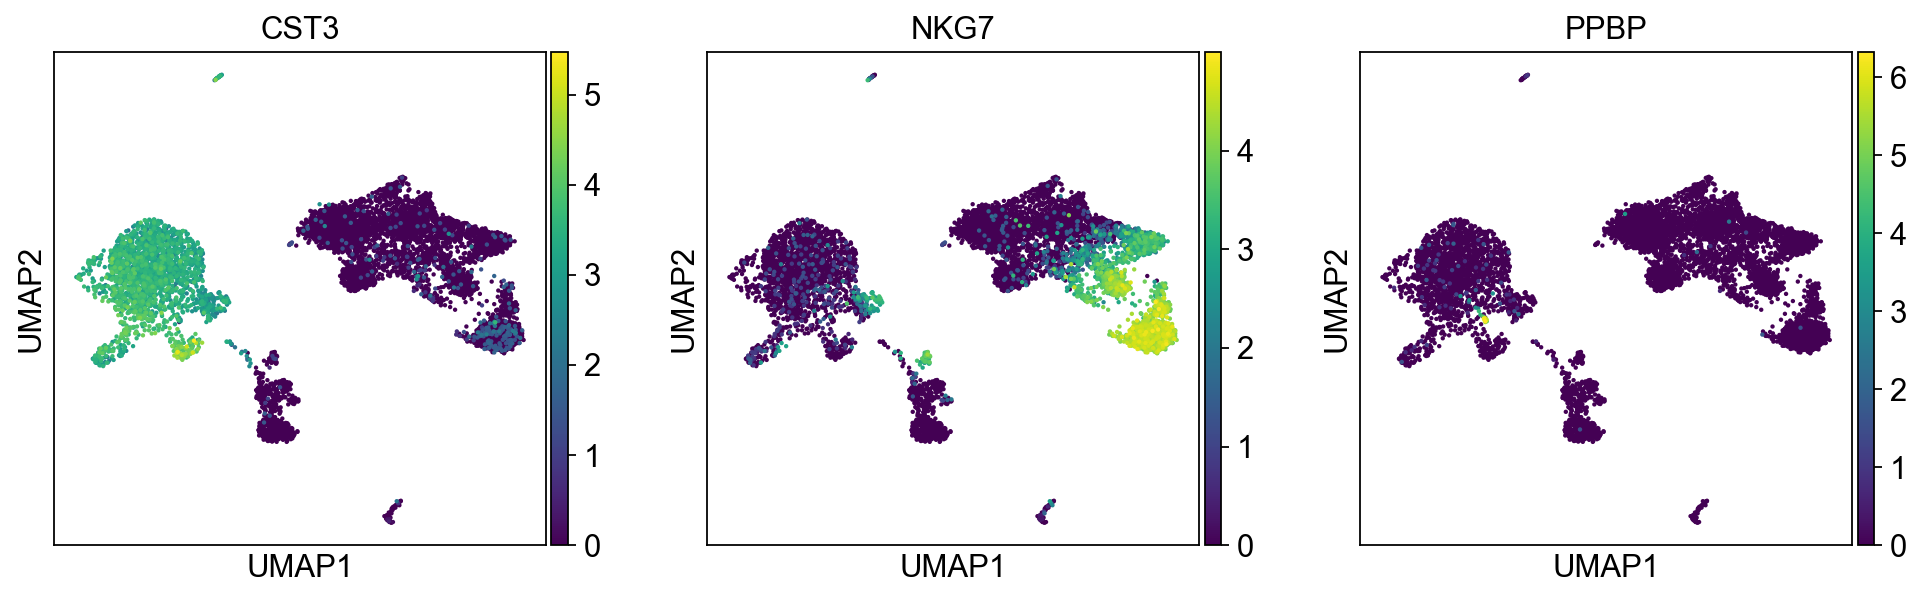

In [23]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

In [24]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:02.51) --> found 16 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


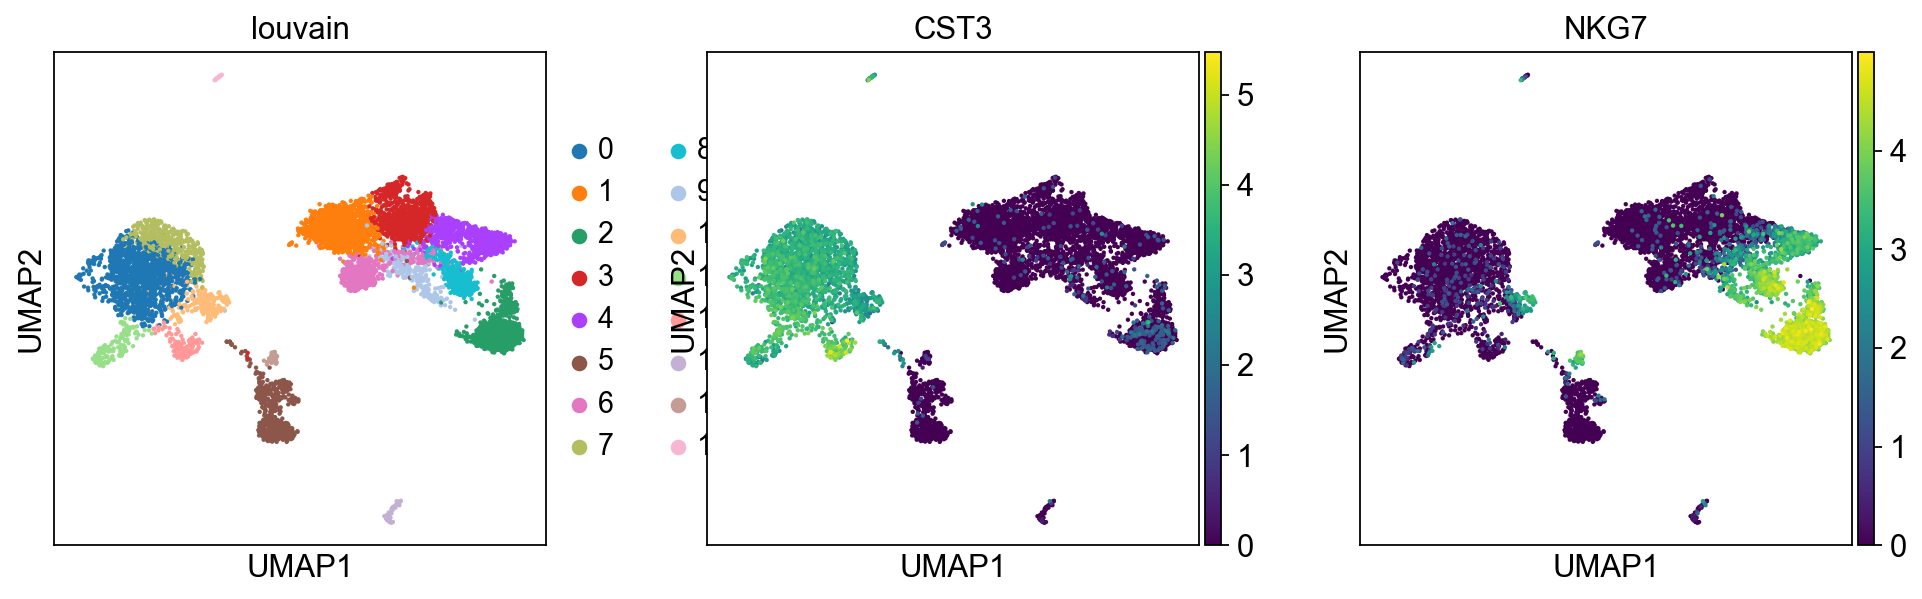

In [25]:
sc.pl.umap(adata, color=['louvain', 'CST3', 'NKG7'])

ranking genes
    finished (0:00:17.22) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


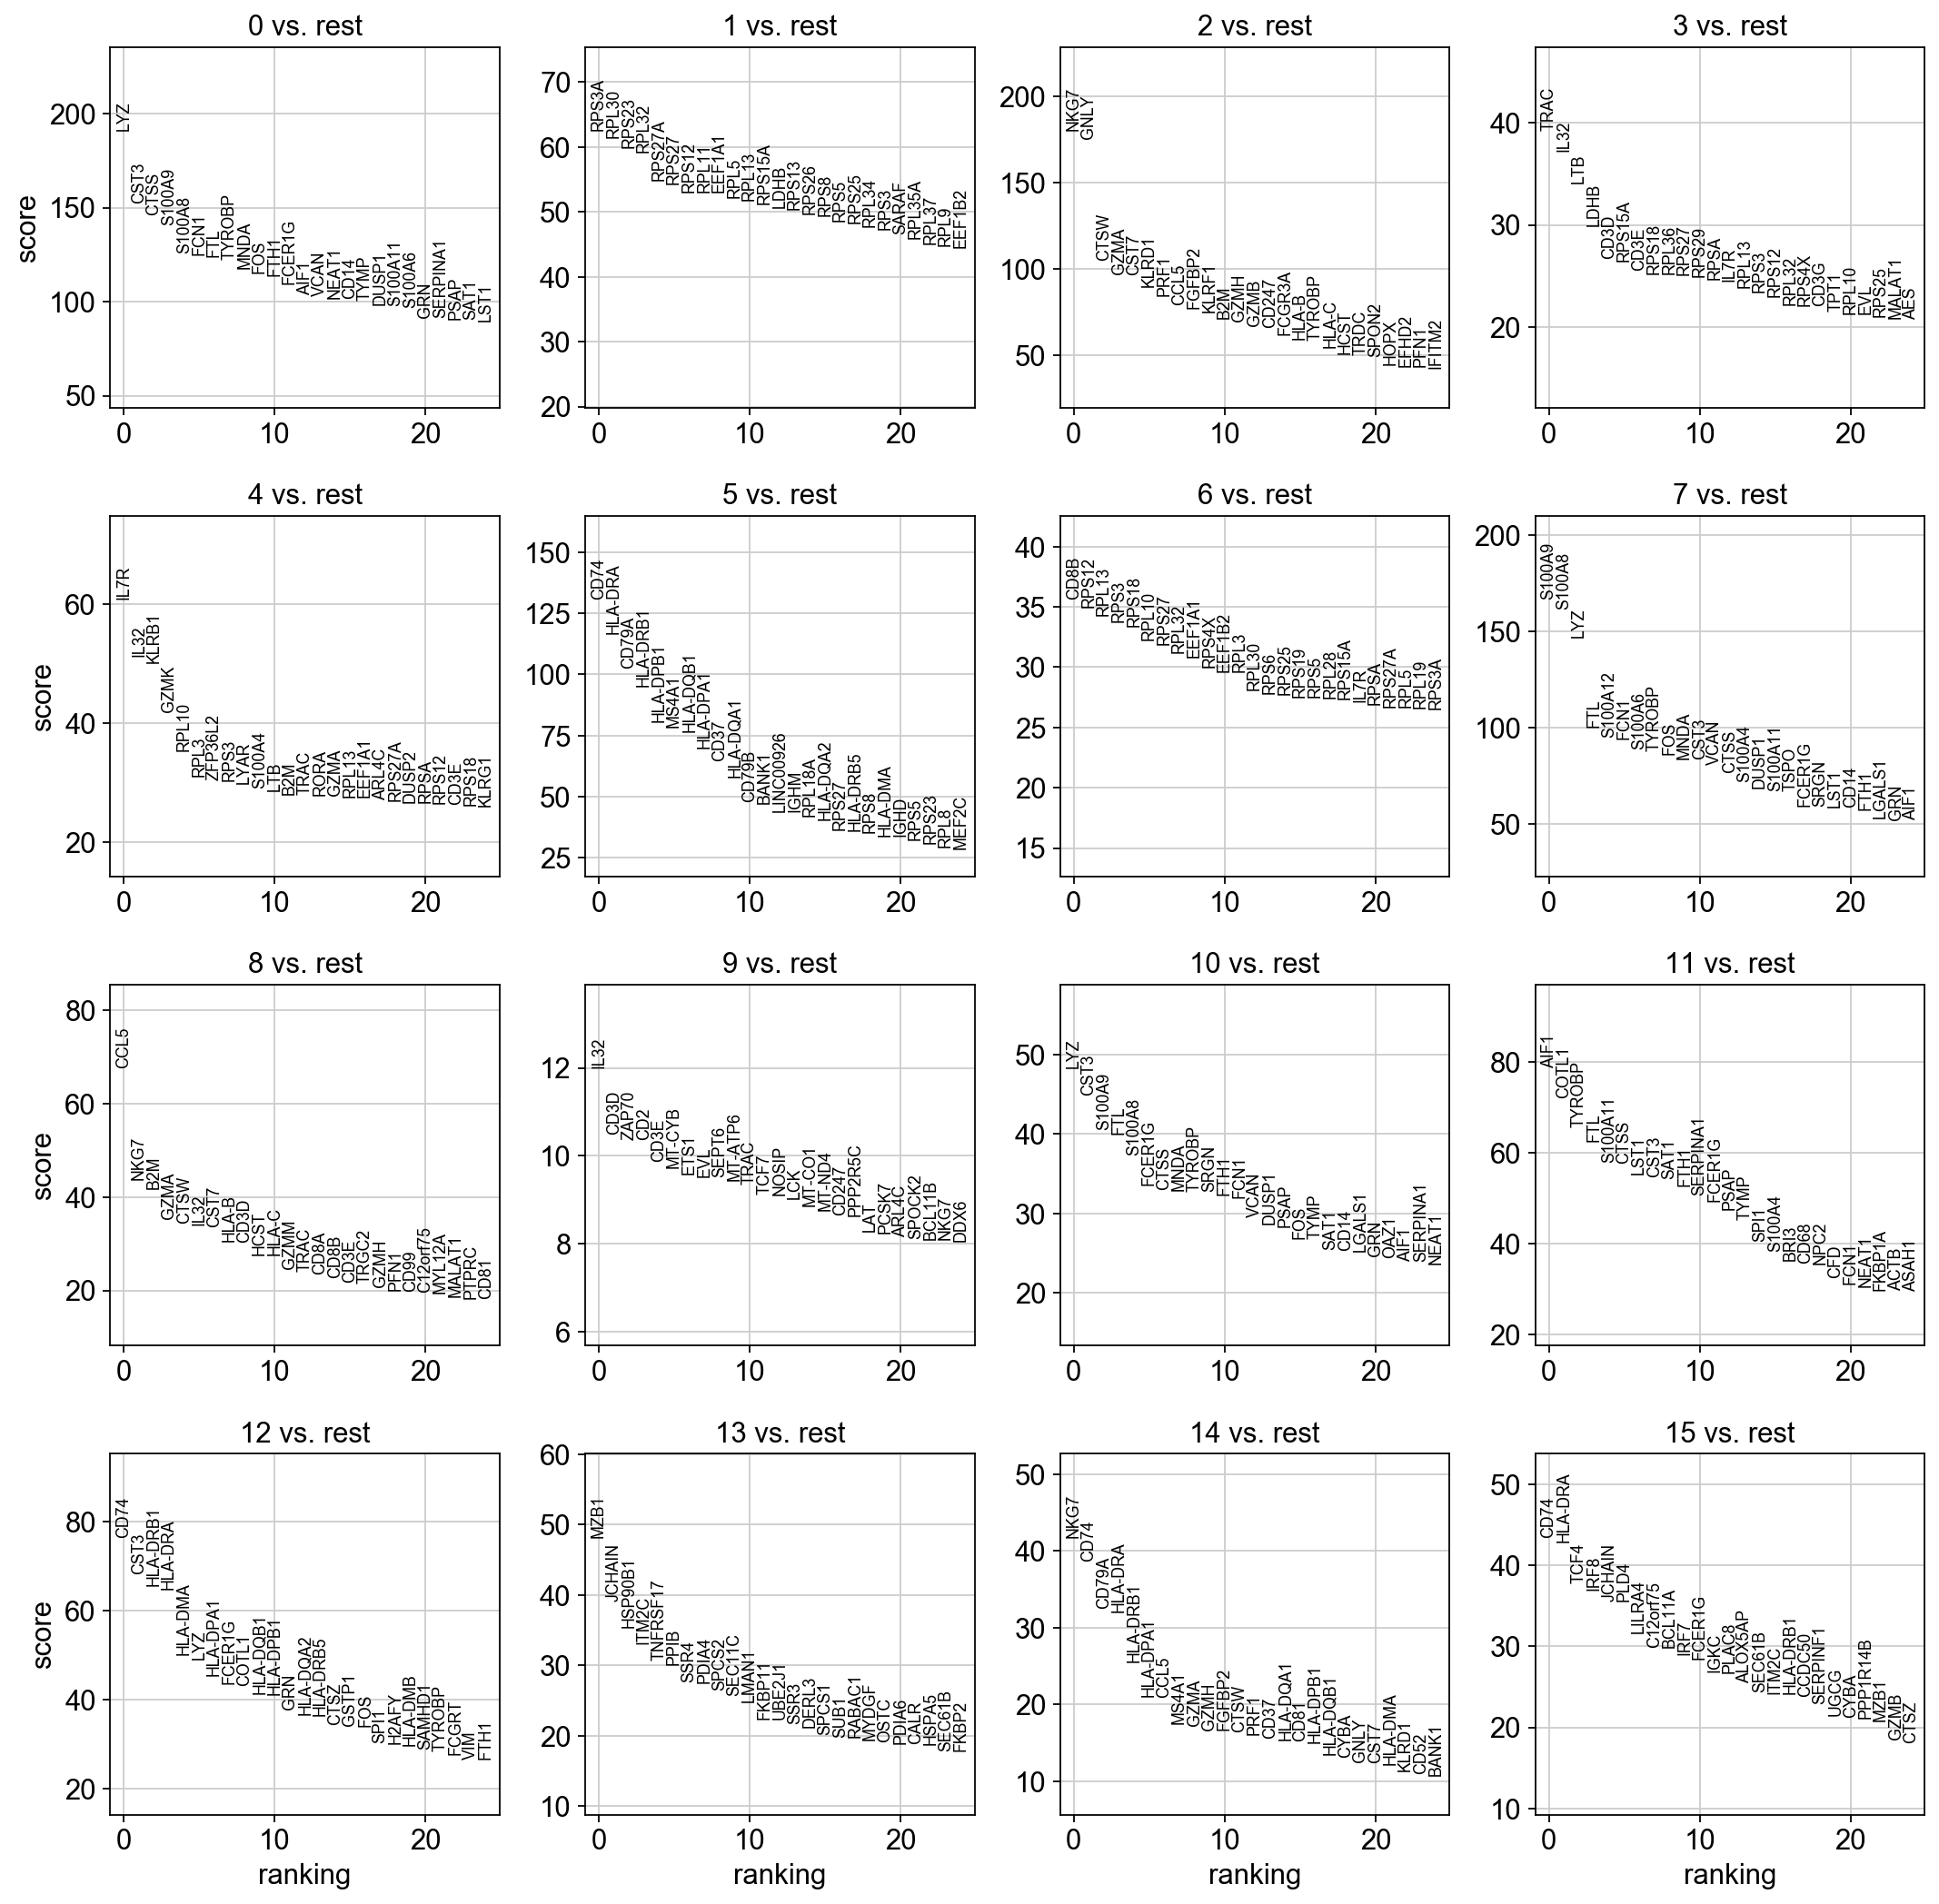

In [26]:
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [27]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

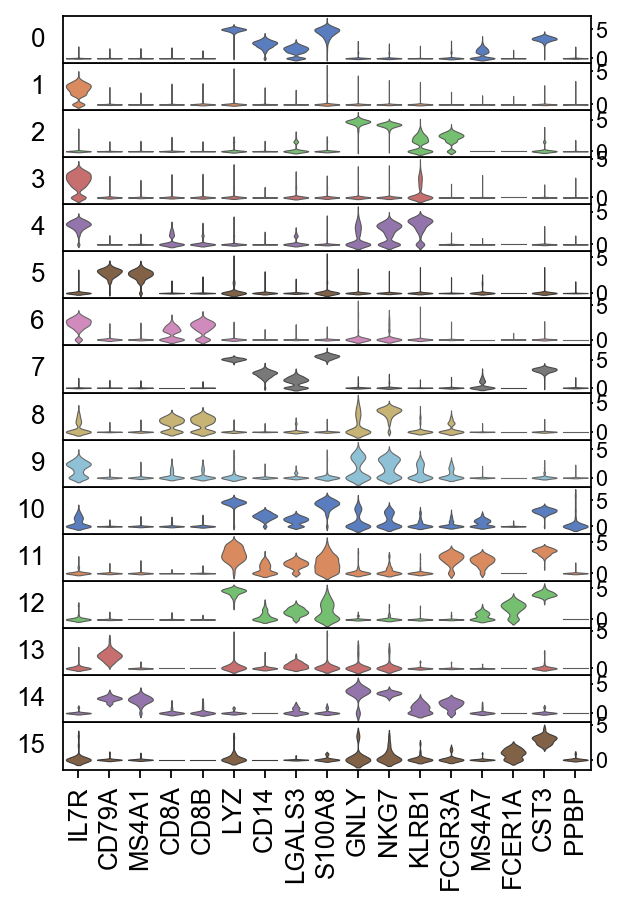

In [28]:
sc.pl.stacked_violin(adata, groupby='louvain', var_names=marker_genes)

In [29]:
#Louvain    Markers       Cell Type
#0          IL7R, CD4     T cells
#1          CD14, LYZ     CD14+ Monocytes
#2          MS4A1         B cells
#3          CD8A, CD8     T cells
#4          GNLY, NKG7    NK cells
#5          FCGR3A, MS4A7 FCGR3A+ Monocytes
#6          FCER1A, CST3  Dendritic Cells
#7          PPBP          Megakaryocytes

new_cluster_names = [
    'CD4 T', 'CD14+ Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A+ Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('louvain', new_cluster_names)

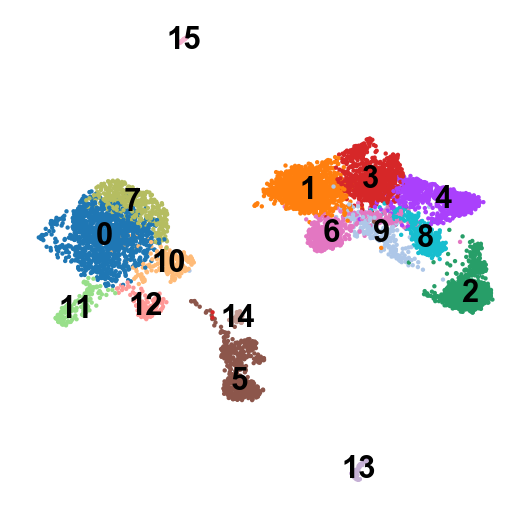

In [30]:
sc.pl.umap(adata, color='louvain', legend_loc='on data', title='', frameon=False)

In [31]:
adata.write_h5ad(results_file, compression='gzip')